# Estimating Velocity from Position

In [1]:
# install dependencies
# !pip install numpy matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def kalman_filter(system_initial_values, estimate_and_covar_initial_values, measurements):
    # arrays for tracking
    x_estimates = []
    K_values = []
    P_values = []

    # initialize system variables
    A, H, Q, R = system_initial_values

    # check if shapes of matrices are correct
    assert A.shape[0] == A.shape[1], "A must be square"
    assert A.shape == Q.shape, "A and Q must be same shape"
    assert H.shape[1] == A.shape[1], "H must match state dimensions"


    # Step 0: Set initial values
    x, P = estimate_and_covar_initial_values

    # main loop: Prediction + Estimation
    for k in range(len(measurements)):
        # Step 1: Predict State and Error Covariance
        x_pred = A @ x
        P_pred = A @ P @ A.T + Q

        # Step 2: Compute the Kalman Gain
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)

        # Step 3: Compute the Estimate
        x = x_pred + K @ (measurements[k] - H @ x_pred)

        # Step 4: Compute the Error Covariance
        P = P_pred - K @ H @ P_pred

        # add current estimate to array for tracking
        x_estimates.append(x.copy())
        K_values.append(K.copy())
        P_values.append(P.copy())
    
    return {
            "final_estimate": x, 
            "estimates_over_time": x_estimates, 
            "kalman_gains": K_values, 
            "error_covariances": P_values
        }

In [7]:
# function to get true position data (what we want to estimate with kalman filter)
def get_true_position_data(dt, t):
    true_position_data = []
    nSamples = int(t / dt)

    for k in range(nSamples):
        time = k * dt
        pos = 2.0 + 0.5 * np.sin(0.5 * time)
        true_position_data.append(pos)
    
    return true_position_data

# helper function to add noise to each datapoint to simulate noisy sensor readings
def get_z_k(k, true_position_data):
    v_k = np.random.normal(0, 0.1)
    return true_position_data[k] + v_k

# function to simulate getting the sonar readings
def get_measurements(dt, t, true_position_data):
    measurements = []
    # dt = time step (s)
    # t = total seconds
    nSamples = int(t / dt)
    for k in range(nSamples):
        measurements.append(get_z_k(k, true_position_data=true_position_data))

    return measurements

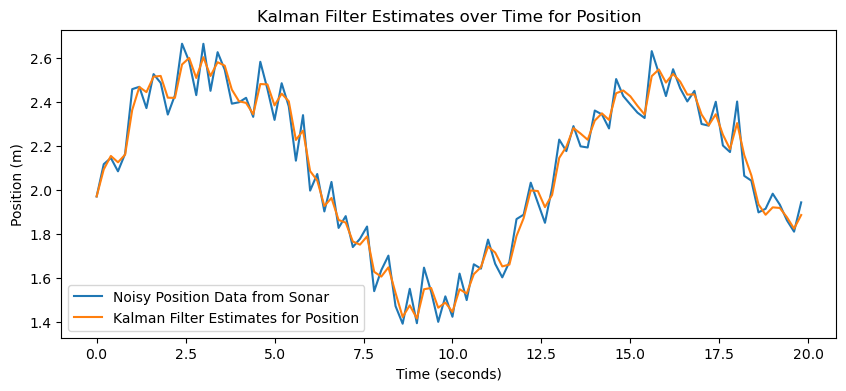

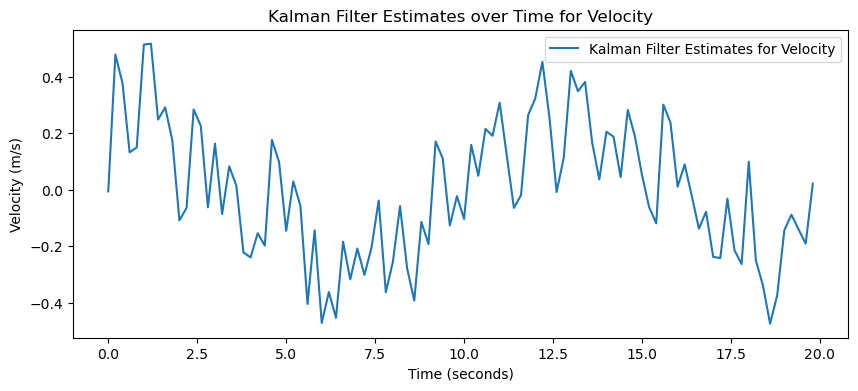

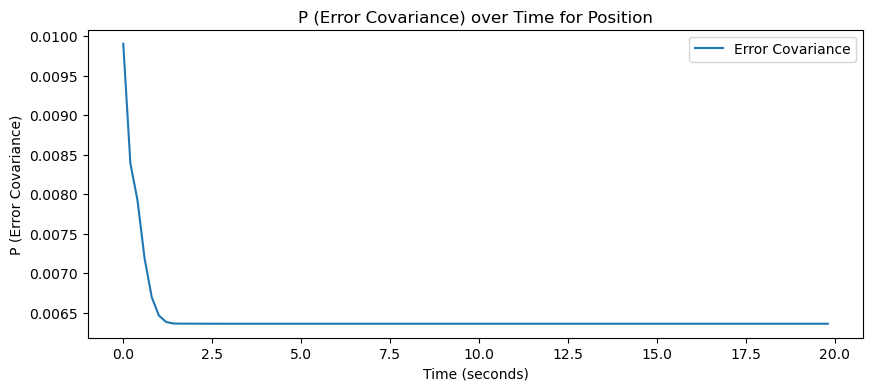

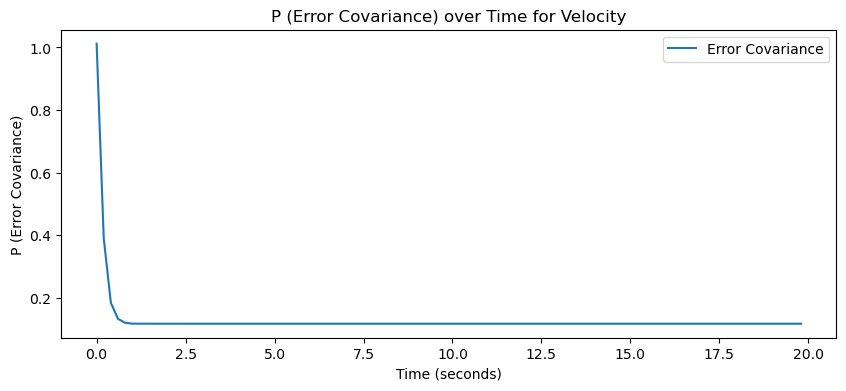

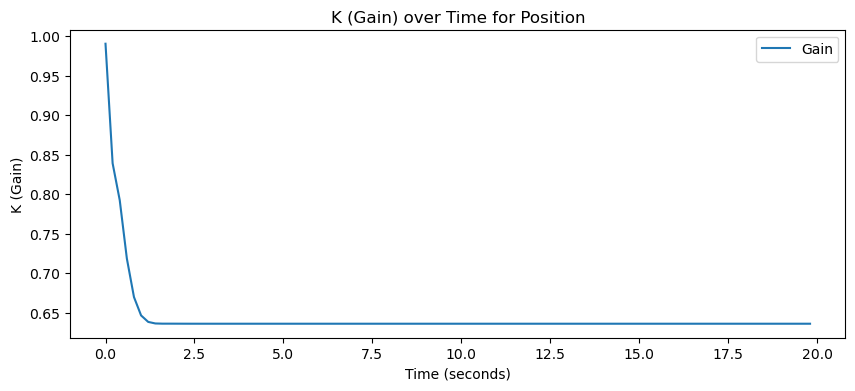

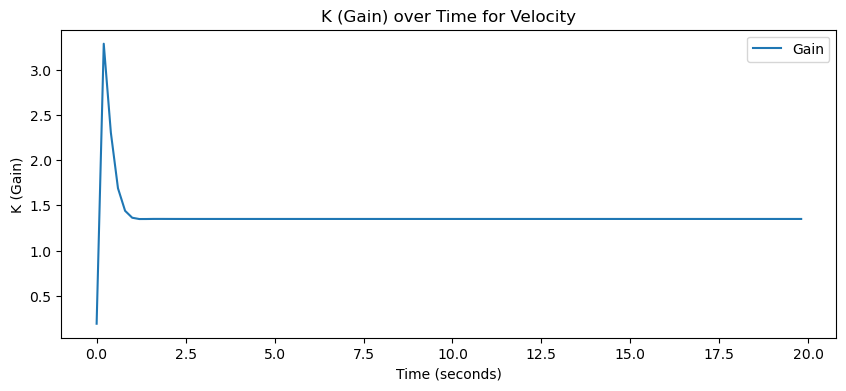

In [16]:
# running the kalman filter

# part 1: simulate sensor data
dt = 0.2
t = 20
true_position_data = get_true_position_data(dt, t)
position_data = get_measurements(dt, t, true_position_data)

# part 2: run kalman filter

# set initial values
initial_A = np.array([[1, dt],
                     [0, 1]])
initial_H = np.array([[1, 0]])
initial_Q = np.array([[0.001, 0],
                      [0,     0.05]])   # modest process noise
initial_R = np.array([[0.01]])          # matches σ = 0.1 m sensor noise
initial_x = np.array([[2.0],
                      [0.0]])
initial_P = np.eye(2) * 1.0

results = kalman_filter(
    [initial_A, initial_H, initial_Q, initial_R],
    [initial_x, initial_P],
    position_data
)

# save estimates over time for plotting
final_estimate = results["final_estimate"]
x_estimates = results["estimates_over_time"]
K_values = results["kalman_gains"]
P_values = results["error_covariances"]

# extract positions and velocities from final_estimates for plotting
positions = [x[0, 0] for x in x_estimates]
velocities = [x[1, 0] for x in x_estimates]

# extract correct error covariances and kalman gains for plotting
P_00 = [P[0, 0] for P in P_values] # error covariances for position
P_11 = [P[1, 1] for P in P_values] # error covariances for velocity
K_pos = [K[0, 0] for K in K_values] # kalman gains over time for position
K_vel = [K[1, 0] for K in K_values] # kalman gains over time for velocity


# part 3: plot!
# create shared time axis (in seconds)
n_steps = len(position_data)
time_s = np.arange(n_steps) * dt

# plot kalman filter estimates position
plt.figure(figsize=(10, 4))
plt.title("Kalman Filter Estimates over Time for Position")
plt.plot(time_s, position_data, label="Noisy Position Data from Sonar")
plt.plot(time_s, positions, label="Kalman Filter Estimates for Position")
plt.xlabel("Time (seconds)")
plt.ylabel("Position (m)")

plt.legend()
plt.show()

# plot kalman filter estimates velocity
plt.figure(figsize=(10, 4))
plt.title("Kalman Filter Estimates over Time for Velocity")
plt.plot(time_s, velocities, label="Kalman Filter Estimates for Velocity")
plt.xlabel("Time (seconds)")
plt.ylabel("Velocity (m/s)")

plt.legend()
plt.show()


# plot error covariances
plt.figure(figsize=(10, 4))
plt.title("P (Error Covariance) over Time for Position")
plt.plot(time_s, P_00, label="Error Covariance")
plt.xlabel("Time (seconds)")
plt.ylabel("P (Error Covariance)")

plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title("P (Error Covariance) over Time for Velocity")
plt.plot(time_s, P_11, label="Error Covariance")
plt.xlabel("Time (seconds)")
plt.ylabel("P (Error Covariance)")

plt.legend()
plt.show()

# plot gains
plt.figure(figsize=(10, 4))
plt.title("K (Gain) over Time for Position")
plt.plot(time_s, K_pos, label="Gain")
plt.xlabel("Time (seconds)")
plt.ylabel("K (Gain)")

plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title("K (Gain) over Time for Velocity")
plt.plot(time_s, K_vel, label="Gain")
plt.xlabel("Time (seconds)")
plt.ylabel("K (Gain)")

plt.legend()
plt.show()

#





